In [1]:
import os
import sys
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("..")
from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset
from my_batch import draw_stats

## Load data

Let us load all data at once instead of doing this for every batch because it can all be loaded in memory.

In [2]:
%matplotlib inline
# %env CUDA_VISIBLE_DEVICES=[]

with open('mnist_pics.blk', 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open('mnist_labels.blk', 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)
# src = (full_imgs, full_labs)

In [3]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
lr_history = []

## Train on the original data

In [5]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, stats, lr_history))

In [6]:
max_accuracy = 0
window = 50
sum_window = 0
stop_condition = 0.91

for i in tqdm(range(1000)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)
    if stats[i] > max_accuracy:
        max_accuracy = stats[i]
    if i % 50 == 0:
        cr = sum_window / window * max_accuracy 
        sum_window = sum(stats[i - window + 1: i])
        # do early stopping 
        if cr > stop_condition:
            break

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.34it/s]


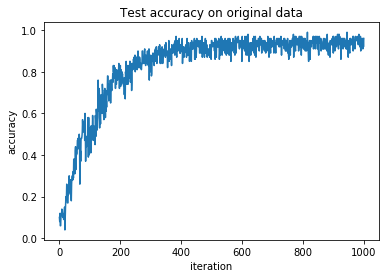

In [9]:
draw_stats(stats, 'Test accuracy on original data')

## Test on augmented data (shifted, rotated, scaled)

In [10]:
ppl_test_shift = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            shift_flattened_pic().
            random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
            random_scale(p=1, factor=(.8, 1.2)).
            update_stats(sess, stats, lr_history))

In [11]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.20it/s]


Predictably we see that our net badly predicts augmented data

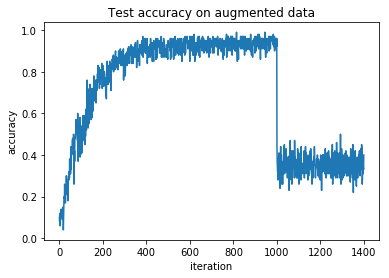

In [12]:
draw_stats(stats, title='Test accuracy on augmented data')

Let's see some examples where the net makes mistakes:

In [13]:
pics = []
y_true = []
y_predict = []
probs = []

ppl_results = (mnistset.test.pipeline().
    load(src=src, fmt='ndarray').
    shift_flattened_pic().
    random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
    random_scale(p=1, factor=(.8, 1.2)).
    predict(sess, pics, y_true, y_predict, probs))

In [14]:
ppl_results.next_batch(100, n_epochs=None)

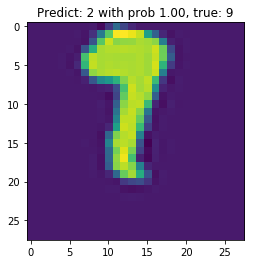

In [18]:
pos = np.where(np.array(y_predict[0]) != np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

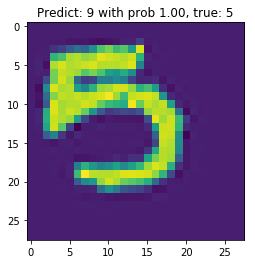

In [16]:
pos = np.where(np.array(y_predict[0]) != np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

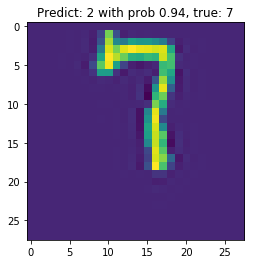

In [19]:
pos = np.where(np.array(y_predict[0]) != np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

## Let's train on augmented data

In [20]:
# pipeline for train
ppl_shift = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       shift_flattened_pic().
       random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
       random_scale(p=1, factor=(.8, 1.2)).
       train_convy(sess))

In [21]:
for i in tqdm(range(1000)):
    ppl_shift.next_batch(100, n_epochs=None)
    ppl_test_shift.next_batch(100, n_epochs=None)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.93it/s]


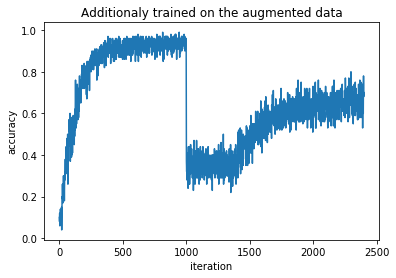

In [22]:
draw_stats(stats, title='Additionaly trained on the augmented data')

In [23]:
pics = []
y_true = []
y_predict = []
probs = []
ppl_results = (mnistset.test.pipeline().
    load(src=src, fmt='ndarray').
    shift_flattened_pic().
    random_rotate(p=1, angle=(-10, 10), preserve_shape=True).
    random_scale(p=1, factor=(.8, 1.2)).
    predict(sess, pics, y_true, y_predict, probs))

In [24]:
ppl_results.next_batch(100, n_epochs=None)

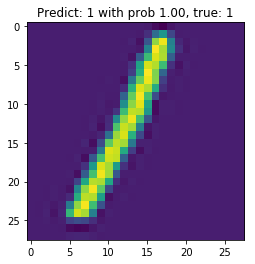

In [25]:
pos = np.where(np.array(y_predict[0]) == np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

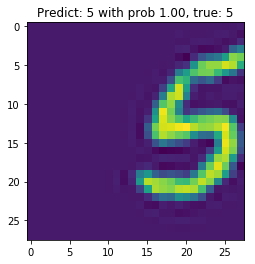

In [26]:
pos = np.where(np.array(y_predict[0]) == np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

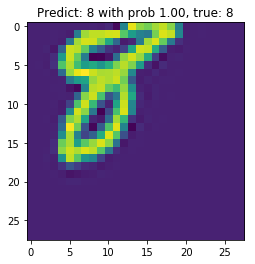

In [27]:
pos = np.where(np.array(y_predict[0]) == np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

But we still have a space for improvement:

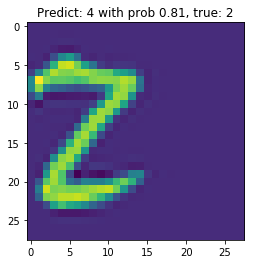

In [36]:
pos = np.where(np.array(y_predict[0]) != np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

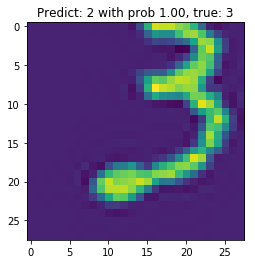

In [46]:
pos = np.where(np.array(y_predict[0]) != np.array(y_true[0]))[0]
item = np.random.randint(len(pos) - 1)
plt.imshow(np.reshape(pics[0][pos[item]], (28, 28)))
plt.title('Predict: %.0f with prob %.2f, true: %.0f' %(y_predict[0][pos[item]], np.amax(probs[0][pos[item]]), y_true[0][pos[item]]))
plt.show()

In [50]:
print ('Average accuracy on shifted data: %.2f %%' % (100.0*np.mean(stats[2000:])))

Average accuracy on shifted data: 64.92 %
